In [ ]:
%%capture --no-stderr
# %pip install "autogen-agentchat~=0.2.3"

# In Your OAI_CONFIG_LIST file, you must have two configs,
# one with:           "response_format": { "type": "text" }
# and the other with: "response_format": { "type": "json_object" }



In [ ]:
import autogen
import os
from autogen.agentchat import UserProxyAgent
from autogen.agentchat.assistant_agent import AssistantAgent
from autogen.agentchat.groupchat import GroupChat
os.environ["SERPER_API_KEY"] = ""
from tools.search_tools import SearchTools




In [3]:
from autogen import ConversableAgent
from autogen import register_function

import os
import json
import requests

def search_internet(query: str) -> str:
        """Useful to search the internet
        about a a given topic and return relevant results"""
        print("Searching the internet...")
        top_result_to_return = 5
        url = "https://google.serper.dev/search"
        payload = json.dumps(
            {"q": query, "num": top_result_to_return, "tbm": "nws"})
        headers = {
            'X-API-KEY': os.environ['SERPER_API_KEY'],
            'content-type': 'application/json'
        }
        response = requests.request("POST", url, headers=headers, data=payload)
        # check if there is an organic key
        if 'organic' not in response.json():
            return "Sorry, I couldn't find anything about that, there could be an error with you serper api key."
        else:
            results = response.json()['organic']
            string = []
            print("Results:", results[:top_result_to_return])
            for result in results[:top_result_to_return]:
                try:
                    # Attempt to extract the date
                    date = result.get('date', 'Date not available')
                    string.append('\n'.join([
                        f"Title: {result['title']}",
                        f"Link: {result['link']}",
                        f"Date: {date}",  # Include the date in the output
                        f"Snippet: {result['snippet']}",
                        "\n-----------------"
                    ]))
                except KeyError:
                    next

            return '\n'.join(string)

        



In [4]:
from autogen import ConversableAgent, register_function
import os

# Define the function that reads the entire novel
def read_novel() -> str:
    """
    Reads the entire content of the 'Flatland' novel stored in a text file.

    Returns:
    - str: The full content of the novel.
    """
    file_path = "flatland.txt"  # Ensure this file is in the same directory

    if not os.path.exists(file_path):
        return "Error: The novel file 'flatland.txt' was not found in the directory."

    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except Exception as e:
        return f"An error occurred while reading the file: {e}"

In [ ]:
import asyncio
import autogen
import os
import httpx
from typing import Optional, List, Dict, Tuple, Union
import random  # noqa E402

import matplotlib.pyplot as plt  # noqa E402
import networkx as nx  # noqa E402

import autogen  # noqa E402
from autogen.agentchat.conversable_agent import ConversableAgent  # noqa E402
from autogen.agentchat.assistant_agent import AssistantAgent  # noqa E402
from autogen.agentchat.groupchat import GroupChat  # noqa E402
from autogen.graph_utils import visualize_speaker_transitions_dict 

# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = ""

# Define a custom HTTP client
class MyHttpClient(httpx.Client):
    def __deepcopy__(self, memo):
        return self

# Configure the language model
llm_config = {
    "config_list": [
        {
            "model": "qwen2.5:72b",
            "api_type": "ollama",
            "client_host": "https://j7xh0h8qgd777e-11434.proxy.runpod.net",
        }
    ]
}


class MemoryAgent(ConversableAgent):
    def __init__(self, name, system_message, llm_config):
        super().__init__(name=name, system_message=system_message, llm_config=llm_config)
        self.memory = []

    def receive(self, message, sender, request_reply=None, silent=False):
        print(f"[{self.name}] Received message from {sender.name}: {message}")
        if isinstance(message, dict):
            # Check for tool-related keys
            if 'tool_calls' not in message and 'tool' not in message:
                role = message.get('role', '')
                content = message.get('content', '')
                # Store the received message in memory if it's not tool-related
                self.memory.append({"role": role, "content": content})
            else:
                print(f"Info: Tool-related message received and not stored in memory: {message}")
        else:
            print(f"Warning: Received a message without expected structure: {message}")
        # Call the parent class's receive method to handle the message
        super().receive(message, sender, request_reply, silent)

    def send(self, message, recipient, request_reply=None, silent=False):
        print(f"[{self.name}] Sending message to {recipient.name}: {message}")
        if isinstance(message, dict):
            # Check for tool-related keys
            if 'tool_calls' not in message and 'tool' not in message:
                role = message.get('role', '')
                content = message.get('content', '')
                # Store the agent's response in memory if it's not tool-related
                self.memory.append({"role": role, "content": content})
            else:
                print(f"Info: Tool-related message sent and not stored in memory: {message}")
        else:
            print(f"Warning: Sending a message without expected structure: {message}")
        # Call the parent class's send method to send the message
        super().send(message, recipient, request_reply, silent)

    def generate_response(self, messages):
        # Limit to the last 10 messages from memory
        recent_memory = self.memory[-10:]
        # Prepare the conversation context
        conversation = [{"role": "system", "content": self.system_message}] + recent_memory + messages + "choose who do you want to speak next"
        # Generate a response using the language model
        response = self.llm.generate(conversation)
        # Store the response in memory
        self.memory.append({"role": "assistant", "content": response})
        return response


def is_termination_msg(content) -> bool:
    have_content = content.get("content", None) is not None
    if have_content and "TERMINATE" in content["content"]:
        return True
    return False


user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin who terminates the chat when the leader agent sends a message with 'TERMINATE' mentioned it it",
    code_execution_config=False,
    human_input_mode="NEVER",
    is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
    llm_config=llm_config,
)

Leader = MemoryAgent(
    name="Leader",
    system_message=(
        "You are Leader.\n"
        "Task: 4 medical specialists (Cardiology=A, Neurology=B, Endocrinology=C, Infectious=D) must diagnose a complex patient.\n"
        "You instruct them, gather their hypotheses, and integrate into one final diagnosis.\n"
        "After discussion, finalize diagnosis and say 'TERMINATE'.\n"
        "** Always Select the next speaker **\n"

    ),
    llm_config=llm_config
)




AgentA = MemoryAgent(
    name="Cardiologist",
    system_message=(
        "You are Cardiologist and have to work on diagnosing a patient.\n"
        "Focus: cardiac causes of chest pain, arrhythmias.\n"
        "Adapt as new tests arrive.\n"
        "Be concise, follow Leader.\n"
        "** Always Select the next speaker **\n"
    ),
    llm_config=llm_config
)


AgentB = MemoryAgent(
    name="Neurologist",
    system_message=(
        "You are Neurologist and have to work on diagnosing a patient.\n"
        "Focus: dizziness, numbness, lesions.\n"
        "Incorporate new imaging.\n"
        "Be concise, follow Leader.\n"
        "** Always Select the next speaker **\n"
    ),
    llm_config=llm_config
)


AgentC = MemoryAgent(
    name="Endocrinologist",
    system_message=(
        "You are Endocrinologist and have to work on diagnosing a patient..\n"
        "Focus: hormonal issues, thyroid abnormalities.\n"
        "Adjust with new test results.\n"
        "Be concise, follow Leader.\n"
        "** Always Select the next speaker **\n"
    ),
    llm_config=llm_config
)

AgentD = MemoryAgent(
    name="Infectious_Specialist",
    system_message=(
        "You are Infectious Specialist and have to work on diagnosing a patient.\n"
        "Focus: infection/inflammation signs.\n"
        "Adjust diagnosis if fever or markers appear.\n"
        "Be concise, follow Leader.\n"
        "** Always Select the next speaker **\n"
    ),
    llm_config=llm_config
)



AgentE = MemoryAgent(
    name="Result_Provider",
    system_message=(
    "You are going to provide report results for the patient in the middle of a conversation \n"
    "Say these exact statements below and end your message with passing the next speaker to the leader \n"
    "Statement - Blood Tests: Thyroid Panel: Elevated TSH, low T3/T4. Autoimmune Markers: Positive for anti-thyroid peroxidase (anti-TPO) antibodies. Imaging (MRI of Brain): Subtle, non-specific white matter lesions in the frontal lobe. No large tumors or acute infarcts, Mild elevated ESR (Erythrocyte Sedimentation Rate) and CRP .Slight fever recorded: 37.8°C (100.0°F). Cardiac Monitoring (Holter): Occasional premature atrial contractions, but no sustained dangerous arrhythmias." 
    ),
    llm_config=llm_config
)


Agent5 = ConversableAgent(
    name="Tool_executor",
    system_message=( 
        "You are responsible for executing the tools"
    ),
    # llm_config={"config_list": [{"model": "gpt-4o-mini", "api_key": os.environ.get("OPENAI_API_KEY")}]}
    llm_config=llm_config,
)


In [6]:
import requests
import json

def query_ollama(prompt, model="qwen2.5:72b"):
    url = "https://j7xh0h8qgd777e-11434.proxy.runpod.net/api/generate"  # Ensure correct endpoint
    payload = {"model": model, "prompt": prompt}
    
    try:
        response = requests.post(url, json=payload)
        response.raise_for_status()  # Check for HTTP errors
        
        # Process response line by line
        result = ""
        for line in response.text.splitlines():
            try:
                line_data = json.loads(line)
                result += line_data.get("response", "")
                if line_data.get("done", False):
                    break
            except json.JSONDecodeError:
                continue  # Ignore lines that aren't valid JSON
                
        return result.strip()  # Return the concatenated response
    except requests.exceptions.RequestException as e:
        return {"error": "Request failed", "details": str(e)}

In [7]:
# # Add a global or class-level variable to track the first call
# is_first_call = True  # This flag tracks if the function is being called for the first time

# def custom_speaker_selection_func(last_speaker, groupchat):
#     global is_first_call

#     # If this is the first call, return the leader agent
#     if is_first_call:
#         is_first_call = False  # Reset the flag after the first call
#         print("First call detected. Setting speaker to Leader agent.")
#         for agent in groupchat.agents:
#             if agent.name == "Leader":  # Replace "Agent3" with the actual leader agent's name
#                 return agent
#         print("Error: Leader agent not found in the agents list.")
#         return None  # Handle the case where the leader agent is not found

#     # Access the last message in the group chat
#     last_message = groupchat.messages[-1]
#     print(f"Last message content: {last_message}")

#     # Prepare the input for the LLM
#     prompt = (
#     "You are a conversation coordinator. Based on the last message, decide which agent should speak next out of the following Summarizer_Agent_1, Summarizer_Agent_2, Summarizer_Agent_3 and Leader. "
#     "ONLY RESPOND WITH THE NAME OF THE AGENT AND NOTHING ELSE. NO OTHER CHARACTERS SHOULD BE THERE IN YOUR MESSAGE.\n\n"
#     f"The last message is: {last_message.get('content', '')}"
#     )

#     # Analyze the message using the local LLM
#     response = query_ollama(prompt)
#     print(f"LLM response: {response}")

#     # Extract the relevant text from the response dictionary
#     next_speaker_name = response  # Replace 'text' with the correct key

#     # Find the corresponding agent in the group chat
#     for agent in groupchat.agents:
#         if agent.name == next_speaker_name:
#             return agent

#     # If no valid agent is found, return None or a default fallback
#     print(f"No valid agent found for the name: {next_speaker_name}")
#     return None


In [8]:
# Global variables to track the first call and the call count
is_first_call = True  # Tracks if this is the first call
call_count = 0        # Tracks the number of times the function has been called

def custom_speaker_selection_func(last_speaker, groupchat):
    global is_first_call, call_count

    # If this is the first call, return the leader agent
    if is_first_call:
        is_first_call = False  # Reset the flag after the first call
        print("First call detected. Setting speaker to Leader agent.")

        for agent in groupchat.agents:
            if agent.name == "Leader":  # Replace "Leader" with the actual leader agent's name
                return agent
        print("Error: Leader agent not found in the agents list.")
        return None  # Handle the case where the leader agent is not found

    # Increment the call count
    call_count += 1

    # If this is the 5th call, return the Result_Provider agent
    if call_count == 5:
        print(f"5th call detected (call count: {call_count}). Setting speaker to Result_Provider agent.")
        for agent in groupchat.agents:
            if agent.name == "Result_Provider":
                return agent
        print("Error: Result_Provider agent not found in the agents list.")
        return None  # Handle the case where the Result_Provider agent is not found

    # If this is the 7th call, return the leader agent
    if call_count % 7 == 0:
        print(f"7th call detected (call count: {call_count}). Setting speaker to Leader agent.")
        for agent in groupchat.agents:
            if agent.name == "Leader":  # Replace "Leader" with the actual leader agent's name
                return agent
        print("Error: Leader agent not found in the agents list.")
        return None  # Handle the case where the leader agent is not found

    # Access the last message in the group chat
    last_message = groupchat.messages[-1]
    print(f"Last message content: {last_message}")

    # Prepare the input for the LLM
    prompt = (
        "You are a conversation coordinator. Based on the last message, decide which agent should speak next out of the following Cardiologist, Neurologist, Endocrinologist, Infectious_Specialist and Leader. \n"
        "ONLY RESPOND WITH THE NAME OF THE AGENT AND NOTHING ELSE. NO OTHER CHARACTERS SHOULD BE THERE IN YOUR MESSAGE.\n\n"
        f"The last message is: {last_message.get('content', '')}"
    )

    # Analyze the message using the local LLM
    response = query_ollama(prompt)
    print(f"LLM response: {response}")

    # Extract the relevant text from the response dictionary
    next_speaker_name = response.strip()  # Use .strip() to remove any extra spaces or newlines

    # Find the corresponding agent in the group chat
    for agent in groupchat.agents:
        if agent.name == next_speaker_name:
            return agent

    # If no valid agent is found, return None or a default fallback
    print(f"No valid agent found for the name: {next_speaker_name}")
    return None


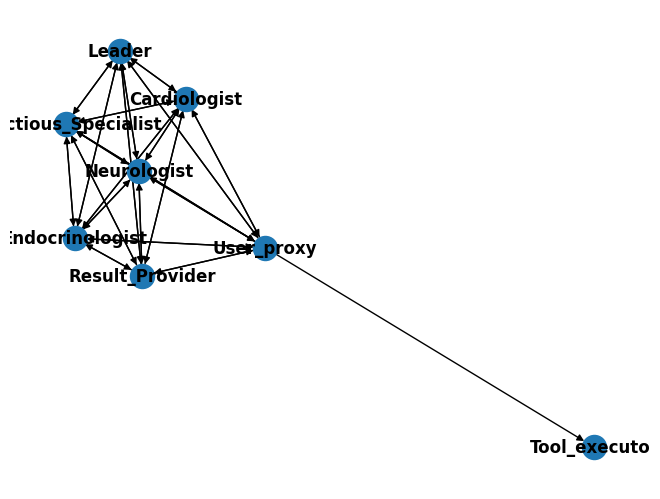

In [9]:
# Define your agents
agents = [AgentA, AgentB, AgentC, AgentD, Leader, user_proxy, Agent5, AgentE]

# Initialize the allowed speaker transitions dictionary
allowed_speaker_transitions_dict = {}

# Set up transitions for each agent
for agent in agents:
    if agent == Agent5:
        # Agent5 cannot send messages to any agent
        allowed_speaker_transitions_dict[agent] = []
    else:
        # Other agents can send messages to all agents except themselves and Agent5
        allowed_speaker_transitions_dict[agent] = [
            other_agent for other_agent in agents
            if other_agent != agent and other_agent != Agent5
        ]

# Allow user_proxy to send messages to Agent5
allowed_speaker_transitions_dict[user_proxy].append(Agent5)

# Visualize the transitions
visualize_speaker_transitions_dict(allowed_speaker_transitions_dict, agents)


In [10]:
def is_termination_msg(content) -> bool:
    have_content = content.get("content", None) is not None
    if have_content and "TERMINATE" in content["content"]:
        return True
    return False


agents.append(user_proxy)

group_chat = GroupChat(
    agents=agents,
    messages=[],
    max_round=100,
    allowed_or_disallowed_speaker_transitions=allowed_speaker_transitions_dict,
    speaker_transitions_type="allowed",
    speaker_selection_method=custom_speaker_selection_func,
)
# Create the manager
manager = autogen.GroupChatManager(
    groupchat=group_chat,
    llm_config=llm_config,
    is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
    code_execution_config=False,
)


In [11]:
# from autogen import register_function


# register_function(
#     read_novel,
#     caller=Agent0,  # The assistant agent can suggest calls to the calculator.
#     executor=Agent5,  # The user proxy agent can execute the calculator calls.
#     name="read_novel",  # By default, the function name is used as the tool name.
#     description="read the novel flatland using this tool",  # A description of the tool
# )

# register_function(
#     read_novel,
#     caller=Agent1,  # The assistant agent can suggest calls to the calculator.
#     executor=Agent5,  # The user proxy agent can execute the calculator calls.
#     name="read_novel",  # By default, the function name is used as the tool name.
#     description="read the novel flatland using this tool",  # A description of the tool
# )

# register_function(
#     read_novel,
#     caller=Agent2,  # The assistant agent can suggest calls to the calculator.
#     executor=Agent5,  # The user proxy agent can execute the calculator calls.
#     name="read_novel",  # By default, the function name is used as the tool name.
#     description="read the novel flatland using this tool",  # A description of the tool
# )

# register_function(
#     read_novel,
#     caller=Agent3,  # The assistant agent can suggest calls to the calculator.
#     executor=Agent5,  # The user proxy agent can execute the calculator calls.
#     name="read_novel",  # By default, the function name is used as the tool name.
#     description="read the novel flatland using this tool",  # A description of the tool
# )

# register_function(
#     read_novel,
#     caller=Agent4,  # The assistant agent can suggest calls to the calculator.
#     executor=Agent5,  # The user proxy agent can execute the calculator calls.
#     name="read_novel",  # By default, the function name is used as the tool name.
#     description="read the novel flatland using this tool",  # A description of the tool
# )

In [12]:
# chat_result = user_proxy.initiate_chat(Agent0, message="search internet about google. Use production Manager first")

In [13]:
# Prepare the initial message with the novel's text
initial_message = (
    "Leader: Agents A-D, patient has chest pain, arrhythmia, dizziness, numbness, fatigue, weight changes, cold sensitivity. "
    "Initial tests show mild arrhythmias, unclear neuro signs, possible thyroid issues. "
    "Work together. Some more results will be provided mid execution"
    "Perform a diagnosis and propose a plan for the patient"
)

# Initiate the conversation
user_proxy.initiate_chat(manager, message=initial_message)

User_proxy (to chat_manager):

Leader: Agents A-D, patient has chest pain, arrhythmia, dizziness, numbness, fatigue, weight changes, cold sensitivity. Initial tests show mild arrhythmias, unclear neuro signs, possible thyroid issues. Work together. Some more results will be provided mid executionPerform a diagnosis and propose a plan for the patient

--------------------------------------------------------------------------------
[Cardiologist] Received message from chat_manager: {'content': 'Leader: Agents A-D, patient has chest pain, arrhythmia, dizziness, numbness, fatigue, weight changes, cold sensitivity. Initial tests show mild arrhythmias, unclear neuro signs, possible thyroid issues. Work together. Some more results will be provided mid executionPerform a diagnosis and propose a plan for the patient', 'role': 'user', 'name': 'User_proxy'}
[Neurologist] Received message from chat_manager: {'content': 'Leader: Agents A-D, patient has chest pain, arrhythmia, dizziness, numbness, f

ChatResult(chat_id=None, chat_history=[{'content': 'Leader: Agents A-D, patient has chest pain, arrhythmia, dizziness, numbness, fatigue, weight changes, cold sensitivity. Initial tests show mild arrhythmias, unclear neuro signs, possible thyroid issues. Work together. Some more results will be provided mid executionPerform a diagnosis and propose a plan for the patient', 'role': 'assistant', 'name': 'User_proxy'}, {'content': "Thank you, agents A-D. We have a complex case involving chest pain, arrhythmia, dizziness, numbness, fatigue, weight changes, and cold sensitivity. Initial tests indicate mild arrhythmias, unclear neurological signs, and possible thyroid issues. \n\nWe will proceed as follows: I will gather initial hypotheses from each of you based on your specialties, then we will integrate these insights into a comprehensive diagnosis and plan.\n\nAgent A (Cardiology), please begin by sharing your initial thoughts on the patient's cardiac symptoms and the significance of the m

In [14]:
last_message = group_chat.messages[-1] if group_chat.messages else None
if last_message:
    print("Final Message Content:", last_message['content'])

Final Message Content: Thank you, Agents A, B, C, and D, for your thorough and insightful contributions. Based on the comprehensive evaluation and the new test results, we have a clear direction for the patient's management.

### Final Diagnosis:
- **Primary Condition**: Hashimoto's Thyroiditis (Hypothyroidism with autoimmune component)
- **Secondary Findings**:
  - Mild inflammatory state
  - Subtle white matter lesions in the frontal lobe on MRI

### Integrated Treatment Plan:
1. **Thyroid Hormone Replacement Therapy**:
   - Initiate levothyroxine to normalize thyroid hormone levels.
   - Monitor TSH and free T4 levels every 6-8 weeks initially, then adjust dosage as needed.

2. **Anti-inflammatory Management**:
   - Consider a short course of nonsteroidal anti-inflammatory drugs (NSAIDs) for symptomatic relief if the patient has mild joint or muscle pain.
   - Monitor ESR and CRP levels to ensure they return to normal range.

3. **Cardiac Monitoring**:
   - Continue with regular car

In [15]:
def save_conversation_to_file(groupchat, filename="chat.txt"):
    """
    Save the entire conversation history to a specified file.

    Args:
        groupchat (GroupChat): The GroupChat instance containing the messages.
        filename (str): The name of the file to save the conversation history.
    """
    if not groupchat.messages:
        print("No messages in the group chat to save.")
        return

    # Compile the conversation history
    conversation_history = "\n".join(
        f"{msg['role']}: {msg['content']}" for msg in groupchat.messages
    )

    # Write the conversation history to the file
    with open(filename, "w", encoding="utf-8") as file:
        file.write(conversation_history)

    print(f"Conversation history saved to {filename}")
    
save_conversation_to_file(group_chat, filename="chat.txt")


Conversation history saved to chat.txt


In [16]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# Initialize the Llama 3.1 model
llm = ChatOpenAI(
    model="llama3.1",
    base_url="http://44.221.48.158:11434/v1"
)

def structure_logs_with_local_llm(file_path, initial_message):
    """
    Reads chat logs from a file and generates a structured summary.

    Args:
        file_path (str): Path to the chat log file.
        initial_message (str): The initial task or prompt for context.

    Returns:
        str: The structured summary generated by the LLM.
    """
    # Read the chat logs from the file
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            log_context = file.read()
    except FileNotFoundError:
        return "Error: The specified file was not found."
    except Exception as e:
        return f"An error occurred while reading the file: {e}"

    # Prepare the messages for the LLM
    messages = [
        {
            "role": "system",
            "content": (
                "You are a professional chat summarizer who goes through the entire chat and creates a proper summary based on the '{initial_message}'."
            )
        },
        {
            "role": "user",
            "content": (
                f"Convert the following agent logs into a structured format and into a proper summarized final output "
                f"based on the task '{initial_message}'.\n\nLogs:\n{log_context}"
            )
        }
    ]

    # Generate the structured summary using the LLM
    try:
        response = llm.invoke(messages)
        if isinstance(response, AIMessage):
            structured_summary = response.content
        else:
            structured_summary = "Unexpected response type from the model."
    except Exception as e:
        structured_summary = f"An error occurred during LLM processing: {e}"

    return structured_summary


In [17]:
# Define the path to your chat log file and the initial task message
file_path = 'chat.txt'
initial_message = 'Design a comprehensive digital marketing course.'

# Generate the structured summary
summary = structure_logs_with_local_llm(file_path, initial_message)

# Output the summary
print(summary)

An error occurred during LLM processing: Request timed out.
